## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
!wget  -P ../data $data

--2025-10-24 19:06:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 429 Too Many Requests
2025-10-24 19:06:51 ERROR 429: Too Many Requests.



In [3]:
df = pd.read_csv('../data/course_lead_scoring.csv')
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns
numeric_columns = df.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('converted')

df_train[categorical_columns] = df_train[categorical_columns].fillna('NA')
df_train[numeric_columns] = df_train[numeric_columns].fillna(0.0)

df_val[categorical_columns] = df_val[categorical_columns].fillna('NA')
df_val[numeric_columns] = df_val[numeric_columns].fillna(0.0)
df_test[categorical_columns] = df_test[categorical_columns].fillna('NA')
df_test[numeric_columns] = df_test[numeric_columns].fillna(0.0)

In [7]:
y_train = df_train.converted.values
y_test = df_test.converted.values
y_val = df_val.converted.values

del df_train['converted']
del df_test['converted']
del df_val['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

#### **Answer:**  `number_of_courses_viewed`

In [8]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [9]:
 numeric_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score' ]

In [35]:
from sklearn.metrics import roc_auc_score

scores = {}

for col in numeric_columns:
    auc = roc_auc_score(y_train, df_train[col])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    
    scores[col] = auc

scores

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [11]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000,random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]


In [13]:
y_val.mean()

np.float64(0.5836177474402731)

In [14]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.817

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [15]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t )
    predict_negative = (y_pred < t )

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if (tp + fp) == 0:
        p = 0
    else:
        p = tp / (tp + fp)
    
    if (tp + fn) == 0:
        r = 0
    else:
        r = tp / (tp + fn)

    scores.append((t, p, r))

In [16]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

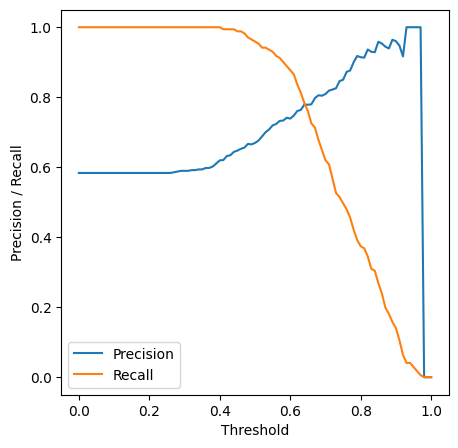

In [17]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')

plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

#### **Answer:**

In [23]:
f1_values = 2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
f1_values = f1_values.fillna(0)  

best_idx = f1_values.idxmax()

best_f1 = {
    'threshold': df_scores.loc[best_idx, 'threshold'],
    'f1': f1_values[best_idx]
}

best_f1

{'threshold': np.float64(0.5700000000000001),
 'f1': np.float64(0.8124999999999999)}

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [29]:
from sklearn.model_selection import KFold

categorical_columns = df_full_train.select_dtypes(include=['object']).columns
numeric_columns = df_full_train.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('converted')

df_full_train[categorical_columns] = df_full_train[categorical_columns].fillna('NA')
df_full_train[numeric_columns] = df_full_train[numeric_columns].fillna(0.0)

y_full_train = df_full_train['converted'].values
del df_full_train['converted']

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train_fold.to_dict(orient='records'))
    X_val = dv.transform(df_val_fold.to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train_fold)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val_fold, y_pred)
    auc_scores.append(auc)

std_auc = np.std(auc_scores)
std_auc

np.float64(0.03580711942905165)

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

#### **Answer:**

In [32]:
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        X_train_fold = df_full_train.iloc[train_idx]
        X_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train_fold.to_dict(orient='records'))
        X_val = dv.transform(X_val_fold.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train_fold)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append({'C': C, 'mean': mean_auc, 'std': std_auc})

In [33]:
df_results = pd.DataFrame(results)
df_results['mean_round'] = df_results['mean'].round(3)
df_results['std_round'] = df_results['std'].round(3)

In [36]:
best = df_results.sort_values(by=['mean_round', 'std_round', 'C'], ascending=[False, True, True]).iloc[0]
best['C']

np.float64(0.001)